In [52]:
import pandas as pd 
import numpy as np
import time
from functools import partial
from glob import glob
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# Importando bases

df_doenca_agg = pd.read_csv('../../../dados/com-clima/doenca_agrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg['cod_muni'] = df_doenca_agg['cod_muni'].astype('int')
df_doenca_agg['ano'] = df_doenca_agg['ano'].astype('int')
df_doenca_agg['prevalencia'] = df_doenca_agg['prevalencia'].astype('float')
df_doenca_agg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_dgg = pd.read_csv('../../../dados/com-clima/doenca_desagrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg['cod_muni'] = df_doenca_dgg['cod_muni'].astype('int')
df_doenca_dgg['ano'] = df_doenca_dgg['ano'].astype('int')
df_doenca_dgg['prevalencia'] = df_doenca_dgg['prevalencia'].astype('float')
df_doenca_dgg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_clima = pd.read_csv('../../../dados/com-clima/clima.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'estacao'], low_memory=False)

df_censo_cs = pd.read_csv('../../../dados/com-clima/censo_com_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

df_censo_ss = pd.read_csv('../../../dados/com-clima/censo_sem_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

def pega_dados(agrupado=True, selecao=True, doenca=None, ano=None, estacao=None):
    '''
    Parametros
    - agrupado: se deve ou não pegar doencas com CID agrupado
    - selecao: se deve ou não pegar dados do Censo com selecao de colunas
    - doenca: se especificado pega somente entradas daquela doença
    - ano: se especificado pega somente as entradas daquele ano
    - estacao: se especificado pega somente entradas daquela estacao

    Retorna 2 dataframes, x e y, com dados de entrada e saida
    '''

    # tratando os parametros
    if agrupado:
        df_total = df_doenca_agg.copy()
    else:
        df_total = df_doenca_dgg.copy()
    df_total.reset_index(inplace=True)

    if doenca: 
        df_total = df_total[df_total['doenca'] == doenca]
    if ano: 
        df_total = df_total[df_total['ano'] == ano]
    if estacao: 
        df_total = df_total[df_total['estacao'] == estacao]

    df_total = pd.merge(df_total, df_clima, on=['cod_muni', 'ano', 'estacao'])
    
    if selecao:
        df_total = pd.merge(df_total, df_censo_cs, on=['cod_muni'])
    else:
        df_total = pd.merge(df_total, df_censo_ss, on=['cod_muni'])

    df_total.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)
    df_total.dropna(inplace=True)

    # separando dataframe
    y = df_total[['prevalencia']]
    x = df_total.drop(columns=['prevalencia'])
    
    return x, y

In [7]:
print(df_censo_cs.head(10))
print(df_censo_ss.head(10))

          renda_media_mora  SITU1_entorno  SITU2_entorno  SITU3_entorno  \
cod_muni                                                                  
290010            0.103943       0.463481            0.0            0.0   
290020            0.036980       0.548910            0.0            0.0   
290030            0.063205       0.887555            0.0            0.0   
290035            0.047801       0.373950            0.0            0.0   
290040            0.047184       0.397165            0.0            0.0   
290050            0.089643       0.203313            0.0            0.0   
290060            0.090371       0.574687            0.0            0.0   
290070            0.225508       0.883480            0.0            0.0   
290080            0.111618       0.539412            0.0            0.0   
290090            0.086445       0.787353            0.0            0.0   

          SITU4_entorno  SITU5_entorno  SITU6_entorno  SITU7_entorno  \
cod_muni                   

In [91]:
explicativas_completas, explicadas_completas = pega_dados(agrupado=False)
explicativas_completas.reset_index(inplace = True)
explicadas_completas.reset_index(inplace = True)

In [92]:
# OneHotEncoding das estações

explicativas_completas['bin_outono'] = np.zeros(len(explicativas_completas))
explicativas_completas['bin_inverno'] = np.zeros(len(explicativas_completas))
explicativas_completas['bin_verao'] = np.zeros(len(explicativas_completas))
explicativas_completas['bin_primavera'] = np.zeros(len(explicativas_completas))

explicativas_completas.loc[explicativas_completas['estacao'] == 'O', 'bin_outono'] = 1
explicativas_completas.loc[explicativas_completas['estacao'] == 'I', 'bin_inverno'] = 1
explicativas_completas.loc[explicativas_completas['estacao'] == 'V', 'bin_verao'] = 1
explicativas_completas.loc[explicativas_completas['estacao'] == 'P', 'bin_primavera'] = 1

In [93]:
explicativas_completas

cod_muni doenca   ano estacao  temp_media  temp_maxima  temp_minima  \
0          290010   A085  2014       O       0.457        0.427        0.511   
1          290010   I603  2014       O       0.457        0.427        0.511   
2          290010   I671  2014       O       0.457        0.427        0.511   
3          290010   I846  2014       O       0.457        0.427        0.511   
4          290010   J450  2014       O       0.457        0.427        0.511   
5          290010   J960  2014       O       0.457        0.427        0.511   
6          290010   K429  2014       O       0.457        0.427        0.511   
7          290010   K805  2014       O       0.457        0.427        0.511   
8          290010    A09  2011       O       0.434        0.365        0.499   
9          290010   I442  2011       O       0.434        0.365        0.499   
10         290010   I501  2011       O       0.434        0.365        0.499   
11         290010    I64  2011       O       0.434        0.365        0.499   
12         290010   I844  2011       O       0.434        0.365        0.499   
13         290010   J359  2011       O       0.434        0.365        0.499   
14         290010   K409  2011       O       0.434        0.365        0.499   
15         290010   K801  2011       O       0.434        0.365        0.499   
16         290010    A09  2012       P       0.489        0.537        0.531   
17         290010   A499  2012       P       0.489        0.537        0.531   
18         290010   I509  2012       P       0.489        0.537        0.531   
19         290010    I64  2012       P       0.489        0.537        0.531   
20         290010   J188  2012       P       0.489        0.537        0.531   
21         290010   J958  2012       P       0.489        0.537        0.531   
22         290010   K429  2012       P       0.489        0.537        0.531   
23         290010   K564  2012       P       0.489        0.537        0.531   
24         290010   K801  2012       P       0.489        0.537        0.531   
25         290010   K808  2012       P       0.489        0.537        0.531   
26         290010   K920  2012       P       0.489        0.537        0.531   
27         290010   K921  2012       P       0.489        0.537        0.531   
28         290010   K928  2012       P       0.489        0.537        0.531   
29         290010    A09  2014       P       0.468        0.486        0.501   
...           ...    ...   ...     ...         ...          ...          ...   
2047164    432380   I638  2011       I       0.245        0.231        0.293   
2047165    432380    I64  2011       I       0.245        0.231        0.293   
2047166    432380   I702  2011       I       0.245        0.231        0.293   
2047167    432380   I714  2011       I       0.245        0.231        0.293   
2047168    432380   I743  2011       I       0.245        0.231        0.293   
2047169    432380   I771  2011       I       0.245        0.231        0.293   
2047170    432380   I801  2011       I       0.245        0.231        0.293   
2047171    432380   I839  2011       I       0.245        0.231        0.293   
2047172    432380   J158  2011       I       0.245        0.231        0.293   
2047173    432380   J159  2011       I       0.245        0.231        0.293   
2047174    432380   J180  2011       I       0.245        0.231        0.293   
2047175    432380   J189  2011       I       0.245        0.231        0.293   
2047176    432380   J358  2011       I       0.245        0.231        0.293   
2047177    432380   J381  2011       I       0.245        0.231        0.293   
2047178    432380   J440  2011       I       0.245        0.231        0.293   
2047179    432380   J449  2011       I       0.245        0.231        0.293   
2047180    432380    J81  2011       I       0.245        0.231        0.293   
2047181    432380    J90  2011       I       0.245        0.231        0.293   
2047182  

In [94]:
explicadas_completas

cod_muni doenca   ano estacao  prevalencia
0          290010   A085  2014       O     0.000121
1          290010   I603  2014       O     0.000121
2          290010   I671  2014       O     0.000121
3          290010   I846  2014       O     0.000121
4          290010   J450  2014       O     0.000121
5          290010   J960  2014       O     0.000121
6          290010   K429  2014       O     0.000121
7          290010   K805  2014       O     0.000121
8          290010    A09  2011       O     0.000121
9          290010   I442  2011       O     0.000121
10         290010   I501  2011       O     0.000241
11         290010    I64  2011       O     0.000121
12         290010   I844  2011       O     0.000121
13         290010   J359  2011       O     0.000121
14         290010   K409  2011       O     0.000241
15         290010   K801  2011       O     0.000121
16         290010    A09  2012       P     0.000361
17         290010   A499  2012       P     0.000121
18         290010   I509  2012       P     0.000843
19         290010    I64  2012       P     0.000241
20         290010   J188  2012       P     0.000121
21         290010   J958  2012       P     0.000121
22         290010   K429  2012       P     0.000241
23         290010   K564  2012       P     0.000121
24         290010   K801  2012       P     0.000121
25         290010   K808  2012       P     0.000121
26         290010   K920  2012       P     0.000121
27         290010   K921  2012       P     0.000121
28         290010   K928  2012       P     0.000121
29         290010    A09  2014       P     0.000121
...           ...    ...   ...     ...          ...
2047164    432380   I638  2011       I     0.000081
2047165    432380    I64  2011       I     0.000403
2047166    432380   I702  2011       I     0.000081
2047167    432380   I714  2011       I     0.000081
2047168    432380   I743  2011       I     0.000081
2047169    432380   I771  2011       I     0.000081
2047170    432380   I801  2011       I     0.000081
2047171    432380   I839  2011       I     0.000323
2047172    432380   J158  2011       I     0.000081
2047173    432380   J159  2011       I     0.000242
2047174    432380   J180  2011       I     0.000887
2047175    432380   J189  2011       I     0.000161
2047176    432380   J358  2011       I     0.000081
2047177    432380   J381  2011       I     0.000081
2047178    432380   J440  2011       I     0.000081
2047179    432380   J449  2011       I     0.000081
2047180    432380    J81  2011       I     0.000081
2047181    432380    J90  2011       I     0.000161
2047182    432380   J942  2011       I     0.000081
2047183    432380   J969  2011       I     0.000081
2047184    432380   K359  2011       I     0.000161
2047185    432380   K409  2011       I     0.000403
2047186    432380   K429  2011       I     0.000081
2047187    432380   K439  2011       I     0.000161
2047188    432380   K564  2011       I     0.000081
2047189    432380   K638  2011       I     0.000081
2047190    432380   K802  2011       I     0.000081
2047191    432380   K804  2011       I     0.000081
2047192    432380   K805  2011       I     0.000403
2047193    432380   K819  2011       I     0.000081

[2047194 rows x 5 columns]

In [95]:
cutoff_incidencia = 0

incidencia_total = []
i=0

for doenca in explicadas_completas['doenca'].unique():
    if i%100 == 0:
        print(i)
    i+=1
    df = explicadas_completas[explicadas_completas['doenca'] == doenca]
    incidencia_total.append([doenca, df['prevalencia'].sum()])
    
incidencia_total = pd.DataFrame(incidencia_total, columns = ['doenca', 'prevalencia total'])

#doencas_principais = incidencia_total[incidencia_total['prevalencia total'] > cutoff_incidencia]
doencas_principais = incidencia_total.sort_values(by = 'prevalencia total', ascending = False)

#print(doencas_principais.sort_values(by = 'prevalencia total', ascending = False).head(5))
#print(doencas_principais.shape)

0
100
200
300


KeyboardInterrupt: 

In [ ]:
doencas_principais.reset_index(inplace=True)
doencas_principais = doencas_principais.loc[:30]
doencas_principais.shape

--- 186.920476436615 seconds --- 0


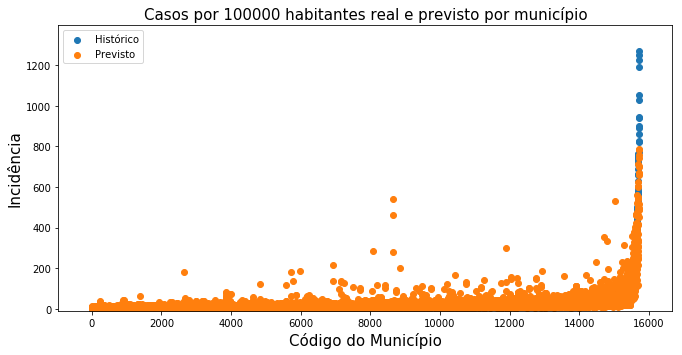

In [111]:
results_final = []
counter = 0
start_time = time.time()


for doenca in ['A499']: #doencas_principais['doenca'].unique():
    
    # Obtenção da doença especifica
    
    df_x = explicativas_completas[explicativas_completas['doenca'] == doenca].copy()
    df_y = explicadas_completas[explicadas_completas['doenca'] == doenca].copy()
    
    #incidencia = df['incidencia'].sum()
    
    #Selecao de colunas corretas para as variaveis x e y
    
    x = df_x[df_x.columns[5:]].reset_index(drop = True) 
    y = df_y['prevalencia'].reset_index(drop = True)
    
    
    # Outlier removal
    removal_upper = 0.00
    removal_lower = 0
    
    outlier_removal_upper = y.nlargest(int(np.ceil(len(y)*removal_upper))).index
    outlier_removal_lower = y.nsmallest(int(np.ceil(len(y)*removal_lower))).index
                                                      
    x.drop(index = outlier_removal_upper, inplace = True)
    y.drop(index = outlier_removal_upper, inplace = True)
    
    x.drop(index = outlier_removal_lower, inplace = True)
    y.drop(index = outlier_removal_lower, inplace = True)
    
    x = x.reset_index(drop = True)
    y = y.reset_index(drop = True)
    
    # Scaling dos dados de prevalência para que ocupe todo o intervalo (0, 1)
    
    scalling_factor = np.max(y)
    y = y/np.max(y)
    
    #Transformação do PCA

    pca_components = 20
    
    if len(y) < pca_components:
        continue
    
    pca = PCA(pca_components)
    x_reduzidas = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_.sum()
    
    #Modelo e parametros
    
    model = LGBMRegressor()
    tuned_parameters = {'n_estimators': [10, 100,1000], 'num_leaves':[10, 30, 100], 'learning_rate':[0.01]}
    scores = {'R2' : 'r2'}
    
    # Kfold train-test split e gridsearch
    
    n_split = 5
    gkf = RepeatedKFold(n_split, n_repeats = 5)
    
    clf = GridSearchCV(LGBMRegressor(), tuned_parameters, cv = gkf, scoring = scores, refit='R2', return_train_score=True)
    clf.fit(x_reduzidas, y)
    
    #Tempo de rodada
    
    print("--- %s seconds ---" % (time.time() - start_time), counter)
    start_time = time.time()
    counter += 1
    
    # Predição e Resultados via LGBM
    
    optimised_LGBM = clf.best_estimator_
    y_predict = optimised_LGBM.predict(x_reduzidas)
    mean_y = np.ones(len(y))*np.mean(y)
    
    rmse_rf = np.sqrt(mean_squared_error(y, y_predict))
    rmse_mean = np.sqrt(mean_squared_error(y, mean_y))
    
    #Regressão Linear
    
    reg_lin = LinearRegression().fit(x_reduzidas, y)
    #y_predict = reg_lin.predict(x_reduzidas)
    
    rmse_linreg = np.sqrt(mean_squared_error(y, y_predict))
        
    
        #Bloco dos gráficos
    
    n_habitantes = 10**5
    
    index = np.argsort(y)
    y = y[index]*scalling_factor*n_habitantes
    y_predict = y_predict[index]*scalling_factor*n_habitantes
    mean_y = mean_y*scalling_factor*n_habitantes
    
    plt.clf()
    plt.scatter(np.arange(0, len(y)), y, label = 'Histórico')
    plt.scatter(np.arange(0, len(y)), y_predict, label = 'Previsto')
    #plt.plot(np.arange(0, len(y)), mean_y*scalling_factor, label = 'media')
    plt.legend()
    plt.title('Casos por 100000 habitantes real e previsto por município', fontsize = 15)
    plt.xlabel('Código do Município', fontsize = 15)
    plt.ylabel('Incidência', fontsize = 15)
    plt.ylim(-10, scalling_factor*1.1*n_habitantes)
    plt.gcf().set_size_inches(11, 5.25)
    plt.gcf().savefig('doença ' + doenca + '.png', dpi=100)
    #plt.xlim(len(y)-100, len(y))
    plt.show()
    
    results_final.append([doenca, explained_variance, clf.best_score_, rmse_rf, rmse_linreg, rmse_mean])

In [113]:
results_final = pd.DataFrame(results_final, columns = ['doenca', 'explained_variance', 'reg_score', 'RMSE_RF', 'RMSE_LinReg', 'RMSE_mean' ])

results_final['ratio_RF'] = results_final['RMSE_RF']/results_final['RMSE_mean']
results_final['ratio_LinReg'] = results_final['RMSE_LinReg']/results_final['RMSE_mean'] 
results_final.sort_values(by = 'ratio_RF', ascending = True, inplace = True)
results_final.reset_index(drop = True, inplace = True)

results_final

doenca  explained_variance  reg_score   RMSE_RF  RMSE_LinReg  RMSE_mean  \
0   A499            0.977313   0.451555  0.021839     0.021839   0.043036   

   ratio_RF  ratio_LinReg  
0  0.507447      0.507447

In [114]:
clf.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=30, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [115]:
clf.cv_results_

{'mean_fit_time': array([0.0366403 , 0.04335879, 0.0661802 , 0.07948002, 0.15692145,
        0.38721534, 0.563795  , 1.26333562, 4.03164923]),
 'std_fit_time': array([0.00191588, 0.00201783, 0.00205392, 0.00291382, 0.01879065,
        0.04596371, 0.02783493, 0.10241939, 0.42202413]),
 'mean_score_time': array([0.00147945, 0.00147974, 0.00148007, 0.00260009, 0.00400024,
        0.00596058, 0.0242614 , 0.03862187, 0.0809926 ]),
 'std_score_time': array([0.00049983, 0.0008543 , 0.00049991, 0.00048984, 0.00093794,
        0.00156115, 0.00660202, 0.00922518, 0.01322518]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 10, 10, 100, 100, 100, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
        